# ADCG variants

* This notebook aims at using ADCG variants (i.e. CGM and CGM-M) on a toy example.

**CGM pseudo code**

For $k = 1, \ldots, k_{\max}$:
  1. Linearize: $\hat{f}_k(s) \leftarrow f(x_k) + \langle \nabla f(x_k), s - x_k \rangle$
  2. Minimize: $s_k \in \arg \min_{s \in C} \hat{f}_k(s)$
  3. Tentative update: $\tilde{x}_{k+1} \leftarrow \frac{k}{k + 2} x_k + \frac{2}{k + 2} s_k$
  4. Final update: Choosse $x_{k+1}$ such that $f(x_{k+1}) \leq f(\tilde{x}_{k+1})$

**CGM-M pseudo code**

For $k = 1, \ldots, k_{\max}$:
  1. Compute gradient of loss: $g_k = \nabla l(\Phi \mu_{k-1} - y)$
  2. Compute next source: $\theta_k \in \arg \min_{\theta \in \Theta} \langle g_k, \psi(\theta) \rangle$
  3. Update support: $S_k \leftarrow S_{k-1} \cup \{\theta_k\}$
  4. Compute weights: $\mu_k \leftarrow \arg \min_{\mu} l(\sum_{\theta \in S_k} \mu(\{\theta\}) \psi(\theta) - y) \; \text{s.t.} \; \mu \geq 0,\; \mu(S_k) \leq \tau,\; \mu(S_k^c) = 0$
  5. Prune support: $S_k \leftarrow \text{Supp}(\mu_k)$

**ADCG pseudo code**

For $k = 1, \ldots, k_{\max}$:
  1. Compute gradient of loss: $g_k = \nabla l(\Phi \mu_{k-1} - y)$
  2. Compute next source: $\theta_k \in \arg \min_{\theta \in \Theta} \langle g_k, \psi(\theta) \rangle$
  3. Update support: $S_k \leftarrow S_{k-1} \cup \{\theta_k\}$
  4. Coordinate descent on nonconvex objective:
  
    **Repeat**:
    1. Compute weights: $\mu_k \leftarrow \arg \min_{\mu} l(\sum_{\theta \in S_k} \mu(\{\theta\}) \psi(\theta) - y) \; \text{s.t.} \; \mu \geq 0,\; \mu(S_k) \leq \tau,\; \mu(S_k^c) = 0$
    2. Prune support: $S_k = \text{Supp}(\mu_k)$
    3. Locally improve support $S_k = \mathbf{local\_descent}((\theta, \mu_k(\{\theta\}) : \theta \in S_k)$
    
Where **local_descent** is a subroutine that takes a measure $\mu_k$ with atomic representation and attempts to use gradient information to reduce the function $(\theta_1, \ldots, \theta_m) \mapsto l(\sum_{i=1}^{m} w_i \psi(\theta_i) - y)$ holding the weights $w_i$ fixed.

## Imports

In [14]:
import autograd.numpy as np
import autograd
import scipy.optimize
import pylab
from time import time
import seaborn as sns
pylab.ion()

## Style

In [15]:
sns.set_style("darkgrid")
pylab.rcParams["lines.linestyle"] = ':'
pylab.rcParams["lines.linewidth"] = 5
pylab.rcParams["figure.figsize"] = (14, 3)

## Global variables

In [16]:
# Global variables
evaluation_points = np.linspace(0, 1, 50)
σ = 0.1

## Gaussian plot example

In [17]:
# Gaussian
def ψ(θ):
    return np.exp(-((evaluation_points - θ) / σ) ** 2)

In [18]:
ψ(0.3).shape

(50,)

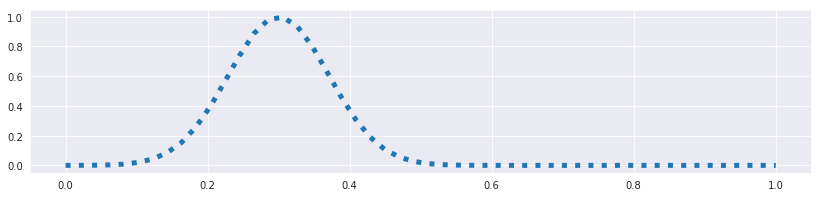

In [19]:
pylab.plot(evaluation_points, ψ(0.3));

## Utility functions

In [20]:
# Weighted shifted gaussian functions
def Ψ(ws, θs):
    return np.sum(np.array([w*ψ(θ) for (w, θ) in zip(ws, θs)]), 0)

In [21]:
# Loss function
def l(ws, θs):
    return ((Ψ(ws, θs) - y) ** 2).sum()

## Problem setting

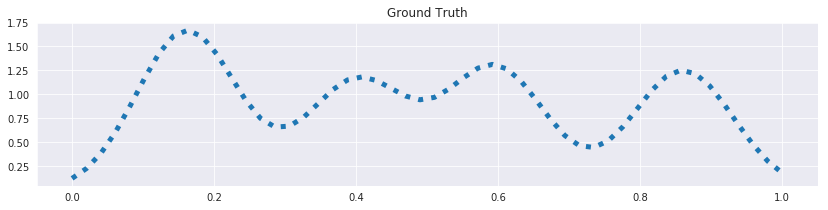

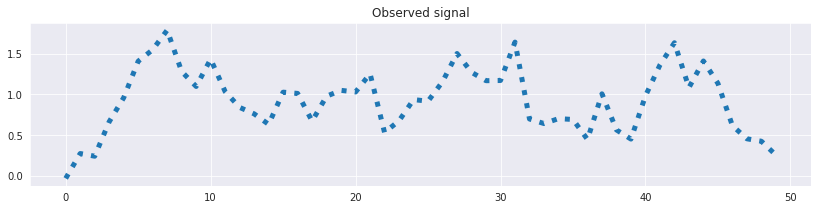

In [22]:
# Generate ground truth θs and weights ws
np.random.seed(69)
num_true_θs = np.random.randint(2, 5)
noise_level = 0.2
true_θs = np.random.rand(num_true_θs)
true_weights = np.random.rand(num_true_θs) + 1
y = (Ψ(true_weights, true_θs) 
     + noise_level * np.random.randn(len(evaluation_points)))
pylab.figure()
pylab.title("Ground Truth")
pylab.plot(evaluation_points, Ψ(true_weights, true_θs))
pylab.figure()
pylab.title("Observed signal")
pylab.plot(y);

In [23]:
# ADCG first step "linear minimization oracle"
# We will grid θ to approximately solve the problem
grid_points = np.linspace(0, 1, 30)
grid_psi = np.stack([ψ(θ) for θ in grid_points])

In [24]:
def lmo(v):
    scores = grid_psi @ v
    return grid_points[scores.argmin()]

In [39]:
# Implement CGM-M
def min_ws(θs):
    return scipy.optimize.nnls(np.stack([ψ(θ) for θ in θs]).T, y)[0]

def CGMM(max_iters):
    θs = np.zeros(0)
    ws = np.zeros(0)
    output = np.zeros(len(evaluation_points))
    history = list()
    for iter in range(max_iters):
        residual = output - y
        loss = (residual**2).sum()
        #print(iter, loss)
        history.append((loss, θs, ws))
        # Compute new support
        θ = lmo(residual)
        θs = np.append(θs, θ)
        # Compute weights
        ws = min_ws(θs)
        output = Ψ(ws, θs)
    return history

# Prune support using heuristic
res = select_k(CGMM(10))

In [26]:
# ADCG second step "coordination optimization solving attempt"
def coordinate_descent(θs, iters=35, min_drop=1e-5):
    def min_ws():
        return scipy.optimize.nnls(np.stack([ψ(θ) for θ in θs]).T, y)[0]
    def min_θs():
        res = scipy.optimize.minimize(
                autograd.value_and_grad(lambda θs: l(ws, θs)),
                                        θs,
                                        jac=True,
                                        method='L-BFGS-B',
                                        bounds=[(0.0, 1.0)]*len(θs))
        return res["x"], res["fun"]
    
    old_f_val = np.inf
    for iter in range(iters):
        ws = min_ws()
        θs, f_val = min_θs()
        # check if loss is stationary
        if old_f_val - f_val < min_drop:
            break
        old_f_val = f_val
    return ws, θs

In [27]:
# ADCG second step "joint optimization solving attempt"
def local_search(θs):
    n = len(θs)
    # Stack weights and θs into a vector
    def f(x):
        return l(x[:n], x[n:])
    x_init = np.concatenate((np.zeros(n), θs))
    res = scipy.optimize.minimize(
            autograd.value_and_grad(f),
            x_init,
            jac=True,
            method="L-BFGS-B",
            bounds=([(0.0, None)]*n) + ([(0.0, 1.0)]*n))
    x = res["x"]
    ws = x[:n]
    θs = x[n:]
    return ws, θs

In [28]:
# Define ADCG
def ADCG(local_update, max_iters):
    θs = np.zeros(0)
    ws = np.zeros(0)
    output = np.zeros(len(evaluation_points))
    history = list()
    for iter in range(max_iters):
        residual = output - y
        loss = (residual**2).sum()
        #print(iter, loss)
        history.append((loss, θs, ws))
        θ = lmo(residual)
        ws, θs = local_update(np.append(θs, θ))
        output = Ψ(ws, θs)
    return history

In [29]:
# Define heuristic for selecting the number of true sources
def select_k(history):
    drop = np.array([history[i][0] - history[i+1][0]
                    for i in range(len(history) - 1)])
    k_hat = np.argmax(drop<0.1)
    return history[k_hat]

Ground truth results
---------------------
True loss: 2.608359358459474
True θs: [0.40157872 0.59582391 0.16174899 0.8603238 ]
True weights: [1.1430533  1.28132229 1.66428121 1.25002847]
---------------------

Coordinate descent results
---------------------
Coordinate descent loss: 2.074
Coordinate descent θs: [0.15096487 0.59086732 0.86430903 0.37707529]
Coordinate descent weights: [1.55972496 1.41077923 1.36876526 1.04324896]
Coordinate descent timing: 1.312s
---------------------

Joint optimization results
---------------------
Local search loss: 2.074
Local search θs: [0.15096361 0.59086983 0.86430868 0.37707719]
Local search weights: [1.55972826 1.41072462 1.36871783 1.04334755]
Local search timing: 1.887s
---------------------

CGM-M results
---------------------
Local search loss: 2.366
Local search θs: [0.17241379 0.5862069  0.86206897 0.37931034 0.06896552]
Local search weights: [1.35850324 1.40908663 1.37257245 0.98065045 0.30597497]
Local search timing: 0.002s
------------

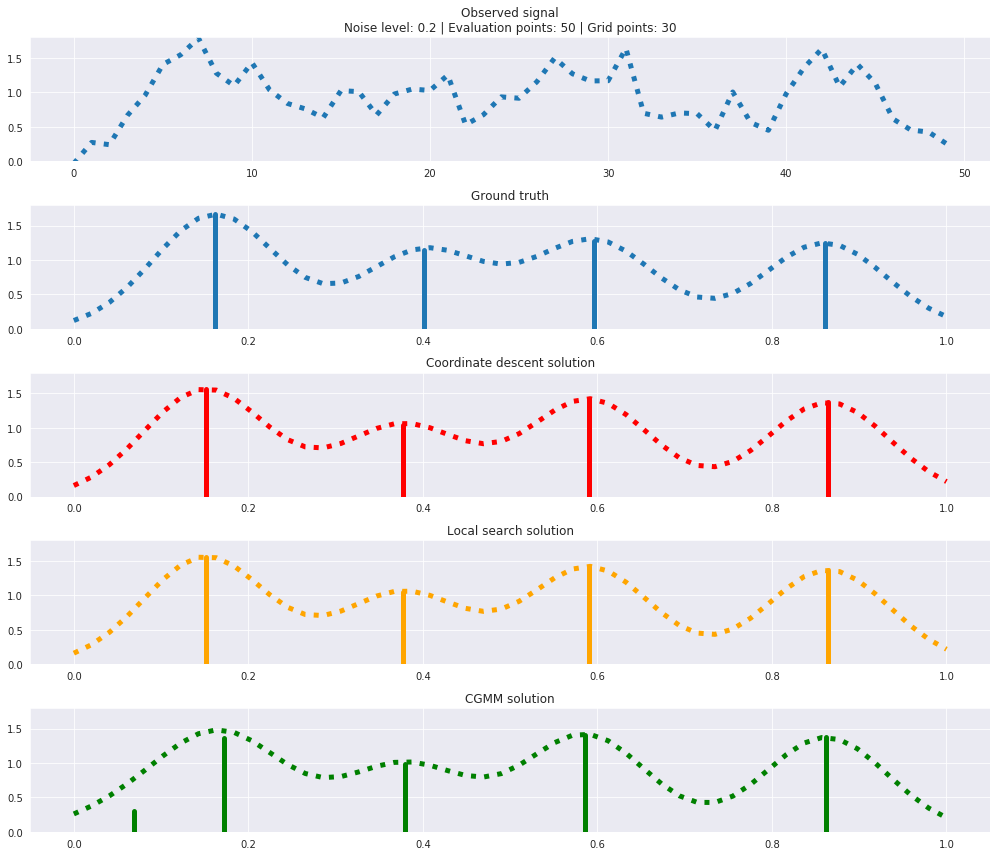

In [41]:
# Let's run it!
start = time()
res_cd = select_k(ADCG(coordinate_descent, 10))
time_cd = time() - start
start = time()
res_ls = select_k(ADCG(local_search, 10))
time_ls = time() - start
start = time()
res_cgmm = select_k(CGMM(10))
time_cgmm = time() - start
# True results
print("Ground truth results")
print("---------------------")
print("True loss:", l(true_weights, true_θs))
print("True θs:", true_θs)
print("True weights:", true_weights)
print("---------------------\n")
# Coordinate descent results
print("Coordinate descent results")
print("---------------------")
print("Coordinate descent loss: %.3f" % res_cd[0])
print("Coordinate descent θs:", res_cd[1])
print("Coordinate descent weights:", res_cd[2])
print("Coordinate descent timing: %.3fs" % time_cd)
print("---------------------\n")
# Joint optimization results
print("Joint optimization results")
print("---------------------")
print("Local search loss: %.3f" % res_ls[0])
print("Local search θs:", res_ls[1])
print("Local search weights:", res_ls[2])
print("Local search timing: %.3fs" % time_ls)
print("---------------------\n")
# Conditional gradient method for measures (CGMM)
print("CGM-M results")
print("---------------------")
print("Local search loss: %.3f" % res_cgmm[0])
print("Local search θs:", res_cgmm[1])
print("Local search weights:", res_cgmm[2])
print("Local search timing: %.3fs" % time_cgmm)
print("---------------------\n")
figure, axes = pylab.subplots(nrows=5, ncols=1, figsize=(14, 12))
for ax in axes[1:]:
    ax.set_ylim(bottom=0., top=1.8)

axes[0].set_ylim(bottom=-0.3, top=2.7)
axes[0].set_title("Observed signal\n"
                  f"Noise level: {noise_level} | "
                  f"Evaluation points: {len(evaluation_points)} | "
                  f"Grid points: {len(grid_points)}")
axes[0].set_ylim(bottom=0., top=1.8)
axes[0].plot(y)
axes[1].set_title("Ground truth")
axes[1].set_ylim(bottom=0., top=1.8)
axes[1].plot(evaluation_points, Ψ(true_weights, true_θs))
for i, θ in enumerate(true_θs):
    axes[1].axvline(x=θ, ymax=true_weights[i] / axes[1].get_ylim()[1],
                    linestyle="-")
axes[2].set_title("Coordinate descent solution")
axes[2].set_ylim(bottom=0., top=1.8)
axes[2].plot(evaluation_points, Ψ(res_cd[2], res_cd[1]), c="red")
for i, θ in enumerate(res_cd[1]):
    axes[2].axvline(x=θ, ymax=res_cd[2][i] / axes[2].get_ylim()[1],
                    linestyle="-", color="red")
axes[3].set_title("Local search solution")
axes[3].set_ylim(bottom=0., top=1.8)
axes[3].plot(evaluation_points, Ψ(res_ls[2], res_ls[1]), c="orange")
for i, θ in enumerate(res_ls[1]):
    axes[3].axvline(x=θ, ymax=res_ls[2][i] / axes[3].get_ylim()[1],
                    linestyle="-", color="orange")
axes[4].set_title("CGMM solution")
axes[4].set_ylim(bottom=0., top=1.8)
axes[4].plot(evaluation_points, Ψ(res_cgmm[2], res_cgmm[1]), c="green")
for i, θ in enumerate(res_cgmm[1]):
    axes[4].axvline(x=θ, ymax=res_cgmm[2][i] / axes[4].get_ylim()[1],
                    linestyle="-", color="green")
pylab.tight_layout();